In [56]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import mysql.connector
from mysql.connector import Error
import pandas as pd
from mysql.connector import Error
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Masking, Reshape, Layer, Lambda, Concatenate, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras import backend as be
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adadelta
from keras.layers import BatchNormalization
from keras.regularizers import l2
import matplotlib.pyplot as plt
import LSTM_preprocessing as pre
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
connection = pre.connect_to_database()
if connection:
    # Query merged data
    merged_df = pre.query_merged_crypto_data(connection)
    # converting US bond yield from hourly to yearly under continous compounding assumptions
    merged_df['yield'] = np.exp(merged_df['yield']*365*24)-1

    # Close the connection
    pre.query_quit(connection)

merged_df.head(3)

Connected to MySQL database, MySQL Server version:  8.0.39
MySQL connection is closed


,lending_rate,borrowing_rate,utilization_rate,stable_borrow_rate,crypto_symbol,date,high,low,close,adj_close,volume,market_cap,coin_supply,yield
0,-50.000000,-50.000000,-50.000000,0.030000,BATUSDT,2020-12-02 14:00:00,0.24,0.24,0.24,0.24,1294545,None,None,0.008552840317602313182744400
1,-50.000000,-50.000000,-50.000000,0.030000,BATUSDT,2020-12-02 15:00:00,0.24,0.24,0.24,0.24,936344,None,None,0.008552840317602313182744400
2,-50.000000,-50.000000,0.013598,0.030000,BATUSDT,2020-12-02 16:00:00,0.24,0.24,0.24,0.24,724626,None,None,0.008552840317602313182744400


### merging with market cap

In [58]:
market_caps = pd.read_csv('market_cap_data.csv')
market_caps = market_caps.rename(columns={
    'timestamp': 'date',
    'token': 'crypto_symbol',
})
market_caps.head(3)

,Unnamed: 0,date,market_cap,crypto_symbol
0,0,2020-12-21 00:00:00,87121414,1INCHUSDT
1,1,2020-12-21 01:00:00,87121414,1INCHUSDT
2,2,2020-12-21 02:00:00,87121414,1INCHUSDT


In [59]:
# Convert 'date' columns to pandas datetime format
merged_df['date'] = pd.to_datetime(merged_df['date'])
market_caps['date'] = pd.to_datetime(market_caps['date'])

# Perform the merge based on 'crypto_symbol' and 'date', keeping only rows in merged_df
merged_df.drop('market_cap', axis = 1, inplace=True)
merged_df = pd.merge(
    merged_df,
    market_caps[['date', 'market_cap', 'crypto_symbol']],
    on=['date', 'crypto_symbol'],
    how='left'
)

merged_df.head(3)

,lending_rate,borrowing_rate,utilization_rate,stable_borrow_rate,crypto_symbol,date,high,low,close,adj_close,volume,coin_supply,yield,market_cap
0,-50.000000,-50.000000,-50.000000,0.030000,BATUSDT,2020-12-02 14:00:00,0.24,0.24,0.24,0.24,1294545,None,0.008552840317602313182744400,317700843.0
1,-50.000000,-50.000000,-50.000000,0.030000,BATUSDT,2020-12-02 15:00:00,0.24,0.24,0.24,0.24,936344,None,0.008552840317602313182744400,317700843.0
2,-50.000000,-50.000000,0.013598,0.030000,BATUSDT,2020-12-02 16:00:00,0.24,0.24,0.24,0.24,724626,None,0.008552840317602313182744400,317700843.0


In [60]:
merged_df.isna().sum()

lending_rate               0
borrowing_rate             0
utilization_rate           0
stable_borrow_rate         0
crypto_symbol              0
date                       0
high                       0
low                        0
close                      0
adj_close                  0
volume                     0
coin_supply           487675
yield                      0
market_cap              5638
dtype: int64

In [61]:
merged_df[merged_df['market_cap'].isna()].head(3)

,lending_rate,borrowing_rate,utilization_rate,stable_borrow_rate,crypto_symbol,date,high,low,close,adj_close,volume,coin_supply,yield,market_cap
66770,-50.000000,-50.000000,-50.000000,0.030000,KNCUSDT,2020-12-02 14:00:00,1.02,1.01,1.01,1.01,66643,None,0.008552840317602313182744400,NaN
66771,-50.000000,-50.000000,-50.000000,0.030000,KNCUSDT,2020-12-02 15:00:00,1.01,1.00,1.01,1.01,81810,None,0.008552840317602313182744400,NaN
66772,-50.000000,-50.000000,0.333333,0.030000,KNCUSDT,2020-12-02 16:00:00,1.01,1.00,1.00,1.00,61898,None,0.008552840317602313182744400,NaN


In [62]:
market_caps[market_caps['crypto_symbol'] == 'KNCUSDT'].head(3)

,Unnamed: 0,date,market_cap,crypto_symbol
226302,226302,2021-07-26 00:00:00,284924659,KNCUSDT
226303,226303,2021-07-26 01:00:00,284924659,KNCUSDT
226304,226304,2021-07-26 02:00:00,284924659,KNCUSDT


In [63]:
# KNC has wrong data before 2021
merged_df = merged_df[merged_df['market_cap'].notna()]
merged_df.reset_index(inplace = True, drop=True)

In [64]:
merged_df_emb = pre.create_llm_embeddings(merged_df, "crypto_symbol", n_components=15)
merged_df_emb = pre.create_cyclical_encodings(merged_df_emb, "date")

In [65]:
merged_df_emb.columns

Index(['lending_rate', 'borrowing_rate', 'utilization_rate',
       'stable_borrow_rate', 'crypto_symbol', 'date', 'high', 'low', 'close',
       'adj_close', 'volume', 'coin_supply', 'yield', 'market_cap',
       'crypto_symbol_embedding_1', 'crypto_symbol_embedding_2',
       'crypto_symbol_embedding_3', 'crypto_symbol_embedding_4',
       'crypto_symbol_embedding_5', 'crypto_symbol_embedding_6',
       'crypto_symbol_embedding_7', 'crypto_symbol_embedding_8',
       'crypto_symbol_embedding_9', 'crypto_symbol_embedding_10',
       'crypto_symbol_embedding_11', 'crypto_symbol_embedding_12',
       'crypto_symbol_embedding_13', 'crypto_symbol_embedding_14',
       'crypto_symbol_embedding_15', 'Month_Sine', 'Month_Cosine', 'Day_Sine',
       'Day_Cosine', 'Hour_Sine', 'Hour_Cosine', 'DayofWeek_Sine',
       'DayofWeek_Cosine'],
      dtype='object')

In [66]:
# data without NA rows if we needed 
filtered_df = merged_df_emb[(merged_df['borrowing_rate'] != -50)&(merged_df['lending_rate'] != -50)&(merged_df['utilization_rate'] != -50)]
filtered_df['attention'] = filtered_df['volume'] * filtered_df['close']
filtered_df.drop(columns=['stable_borrow_rate','adj_close','coin_supply'], inplace=True)
filtered_df[['lending_rate','borrowing_rate','utilization_rate','close', 'volume']] = filtered_df[['lending_rate','borrowing_rate','utilization_rate','close', 'volume']].astype(float)
filtered_df.reset_index(inplace=True, drop=True)
print(len(filtered_df))
filtered_df.columns

413705


Index(['lending_rate', 'borrowing_rate', 'utilization_rate', 'crypto_symbol',
       'date', 'high', 'low', 'close', 'volume', 'yield', 'market_cap',
       'crypto_symbol_embedding_1', 'crypto_symbol_embedding_2',
       'crypto_symbol_embedding_3', 'crypto_symbol_embedding_4',
       'crypto_symbol_embedding_5', 'crypto_symbol_embedding_6',
       'crypto_symbol_embedding_7', 'crypto_symbol_embedding_8',
       'crypto_symbol_embedding_9', 'crypto_symbol_embedding_10',
       'crypto_symbol_embedding_11', 'crypto_symbol_embedding_12',
       'crypto_symbol_embedding_13', 'crypto_symbol_embedding_14',
       'crypto_symbol_embedding_15', 'Month_Sine', 'Month_Cosine', 'Day_Sine',
       'Day_Cosine', 'Hour_Sine', 'Hour_Cosine', 'DayofWeek_Sine',
       'DayofWeek_Cosine', 'attention'],
      dtype='object')

In [67]:
# We scale  market cap, attention, yield together as they are comparable
scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is (0, 1)
filtered_df['yield'] = scaler.fit_transform(filtered_df[['yield']])
filtered_df['market_cap'] = scaler.fit_transform(filtered_df[['market_cap']])
filtered_df['attention'] = scaler.fit_transform(filtered_df[['attention']])

In [68]:
outlier_threshold = 1.5
input_window = 48
output_window = 24
input_columns = ['lending_rate', 'borrowing_rate', 'utilization_rate',
                 'close', 'volume', 'yield', 'market_cap',
       'crypto_symbol_embedding_1', 'crypto_symbol_embedding_2',
       'crypto_symbol_embedding_3', 'crypto_symbol_embedding_4',
       'crypto_symbol_embedding_5', 'crypto_symbol_embedding_6',
       'crypto_symbol_embedding_7', 'crypto_symbol_embedding_8',
       'crypto_symbol_embedding_9', 'crypto_symbol_embedding_10',
       'crypto_symbol_embedding_11', 'crypto_symbol_embedding_12',
       'crypto_symbol_embedding_13', 'crypto_symbol_embedding_14',
       'crypto_symbol_embedding_15', 'Month_Sine', 'Month_Cosine', 'Day_Sine',
       'Day_Cosine', 'Hour_Sine', 'Hour_Cosine', 'DayofWeek_Sine',
       'DayofWeek_Cosine', 'attention','returns']

In [69]:
filtered_df.isna().sum()

lending_rate                  0
borrowing_rate                0
utilization_rate              0
crypto_symbol                 0
date                          0
high                          0
low                           0
close                         0
volume                        0
yield                         0
market_cap                    0
crypto_symbol_embedding_1     0
crypto_symbol_embedding_2     0
crypto_symbol_embedding_3     0
crypto_symbol_embedding_4     0
crypto_symbol_embedding_5     0
crypto_symbol_embedding_6     0
crypto_symbol_embedding_7     0
crypto_symbol_embedding_8     0
crypto_symbol_embedding_9     0
crypto_symbol_embedding_10    0
crypto_symbol_embedding_11    0
crypto_symbol_embedding_12    0
crypto_symbol_embedding_13    0
crypto_symbol_embedding_14    0
crypto_symbol_embedding_15    0
Month_Sine                    0
Month_Cosine                  0
Day_Sine                      0
Day_Cosine                    0
Hour_Sine                     0
Hour_Cos

In [70]:
# Initialize empty lists to store aggregated inputs and targets
all_inputs = []
all_targets = []

# looping through symbols
symbols = filtered_df['crypto_symbol'].unique()
for s in symbols:
     try:
          sim_df = filtered_df[filtered_df['crypto_symbol'] == s]
          sim_df.reset_index(inplace=True, drop=True)
          print(s, len(sim_df))
          # First Loop: Calculate intervals for each column without modifying the DataFrame
          intervals = {}
          for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
               lower, upper = pre.calculate_iqr_bounds(sim_df[column],outlier_threshold)
               intervals[column] = {'lower_bound': lower, 'upper_bound': upper}

          # getting the returns
          reduced_df = sim_df.copy()
          reduced_df['returns'] = pre.calculate_hourly_returns(reduced_df, 'date', 'close')
          reduced_df = reduced_df[reduced_df['returns'].notna()]
          print('rows with valid returns:', len(reduced_df))
          reduced_df.reset_index(inplace=True, drop=True)

          # Second Loop: Filter rows based on the pre-calculated intervals
          for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
               lower_bound = intervals[column]['lower_bound']
               upper_bound = intervals[column]['upper_bound']
               # Apply filtering based on pre-calculated bounds
               reduced_df = reduced_df[(reduced_df[column] > lower_bound) & (reduced_df[column] < upper_bound)]

          reduced_df.reset_index(inplace=True, drop=True)

          # MinMax scaling
          scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is (0, 1)

          scaled_df = reduced_df.copy()
          scaled_df['lending_rate'] = scaler.fit_transform(reduced_df[['lending_rate']])
          scaled_df['borrowing_rate'] = scaler.fit_transform(reduced_df[['borrowing_rate']])
          scaled_df['utilization_rate'] = scaler.fit_transform(reduced_df[['utilization_rate']])
          scaled_df['close'] = scaler.fit_transform(reduced_df[['close']])
          scaled_df['volume'] = scaler.fit_transform(reduced_df[['volume']])
          scaled_df['returns'] = scaler.fit_transform(reduced_df[['returns']])

          inputs, targets = pre.extract_valid_windows_v2(
               scaled_df,
               'date', 
               input_window, output_window, 
               input_columns, 
               ['lending_rate','borrowing_rate']
               )

          # Append results from the current DataFrame
          all_inputs.append(inputs)
          all_targets.append(targets)

          print('input size', inputs.shape)
          print('output size', targets.shape)

     except Exception as e:
        # Handle any other exceptions
        print(f"Unexpected error in symbol {s}: {e}")

BATUSDT 28159
rows with valid returns: 27850
input size (10222, 48, 32)
output size (10222, 2)
LINKUSDT 31934
rows with valid returns: 31598
input size (8765, 48, 32)
output size (8765, 2)
KNCUSDT 22745
rows with valid returns: 22652
input size (3189, 48, 32)
output size (3189, 2)
MKRUSDT 30094
rows with valid returns: 29657
input size (7645, 48, 32)
output size (7645, 2)
MANAUSDT 27145
rows with valid returns: 26560
input size (2858, 48, 32)
output size (2858, 2)
ZRXUSDT 28255
rows with valid returns: 28057
input size (11747, 48, 32)
output size (11747, 2)
SNXUSDT 31087
rows with valid returns: 30477
input size (4984, 48, 32)
output size (4984, 2)
WBTCUSDT 11729
rows with valid returns: 11297
input size (244, 48, 32)
output size (244, 2)
ENJUSDT 27034
rows with valid returns: 26606
input size (7331, 48, 32)
output size (7331, 2)
RENUSDT 27658
rows with valid returns: 27296
input size (7834, 48, 32)
output size (7834, 2)
YFIUSDT 29900
rows with valid returns: 29426
input size (2856, 48

In [71]:
# Concatenate all inputs and targets into single arrays
all_inputs = np.concatenate(all_inputs, axis=0) if all_inputs else np.array([])
all_targets = np.concatenate(all_targets, axis=0) if all_targets else np.array([])
print('total input size', all_inputs.shape)
print('total output size', all_targets.shape)


total input size (84910, 48, 32)
total output size (84910, 2)


In [ ]:
# Lending rate
output_1 = all_targets[:, 0].reshape(all_targets.shape[0], 1) 
# Borrowing rate
output_2 = all_targets[:, 1].reshape(all_targets.shape[0], 1) 
print(output_1.shape) 
print(output_2.shape) 

(84910, 1)
(84910, 1)


In [83]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Masking, Reshape, Layer, Lambda, Concatenate, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.optimizers import Adadelta
from keras.layers import BatchNormalization

def train_v1(inputs, outputs, test_size=0.2, valid_size=0.25, epochs=100, batch_size=200, d1=0.1, d2 = 0.05, cell_size = 80, details=True):
    # Clearing the TensorFlow session to ensure the model starts with fresh weights and biases
    tf.keras.backend.clear_session()
    n_classes = 3

    cell_size_1 = cell_size
    cell_size_2 = cell_size_1//2

    # Splitting the data into train+validation and test sets
    X_train_valid, X_test, y_train_valid, y_test = train_test_split(
        inputs, outputs, test_size=test_size)

    # Splitting the train+validation set into separate training and validation sets
    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train_valid, y_train_valid, test_size=valid_size)

    # Model definition
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
    Lstm_layer_1 = LSTM(cell_size_1, return_sequences=True, stateful=False)(inputs)
    Batch_norm_1 = BatchNormalization()(Lstm_layer_1)
    Dropout_layer_1 = Dropout(d1)(Batch_norm_1)
    Lstm_layer_2 = LSTM(cell_size_2, return_sequences=False, stateful=False)(Dropout_layer_1)  # just halved
    Batch_norm_2 = BatchNormalization()(Lstm_layer_2)
    Drouput_layer_2 = Dropout(d2)(Batch_norm_2)
    predictions = Dense(n_classes, activation='softmax')(Drouput_layer_2)
    LSTM_base = Model(inputs=inputs, outputs=predictions)

  
    # optimizer
    optimizer = Adadelta(
    learning_rate=1.0,
    rho=0.8,
    epsilon=1e-7)      # Default , to prevent division by zero)

    LSTM_base.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

    # Training the model
    history = LSTM_base.fit(x=X_train, y=y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=False,
                    verbose=0)
 
    if details == True:
        LSTM_base.summary()
        fig, ax1 = plt.subplots()

        # Plot losses on the primary y-axis
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss', color='tab:red')
        ax1.plot(history.history['loss'], label='Train Loss', color='red', linestyle='-')
        ax1.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='--')
        ax1.tick_params(axis='y', labelcolor='tab:red')

        # Create a second y-axis for accuracy
        ax2 = ax1.twinx()
        ax2.set_ylabel('Accuracy', color='tab:blue')
        ax2.plot(history.history['accuracy'], label='Train Accuracy', color='blue', linestyle='-')
        ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue', linestyle='--')
        ax2.tick_params(axis='y', labelcolor='tab:blue')

        # Combine legends from both axes
        fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)  # Legend outside the plot

        plt.title('Model Accuracy and Loss')
        plt.tight_layout()  # Adjust layout to avoid clipping
        plt.show()


    y_pred = LSTM_base.predict(X_test)
    y_pred = np.argmax(y_pred, axis=-1)

    return y_test, y_pred

Epoch 1/100
255/255 [==============================] - 23s 71ms/step - loss: 0.7819 - accuracy: 0.6607 - val_loss: 0.6908 - val_accuracy: 0.7006
Epoch 2/100
255/255 [==============================] - 17s 68ms/step - loss: 0.6422 - accuracy: 0.7214 - val_loss: 0.6045 - val_accuracy: 0.7352
Epoch 3/100
255/255 [==============================] - 17s 68ms/step - loss: 0.5943 - accuracy: 0.7415 - val_loss: 0.5538 - val_accuracy: 0.7619
Epoch 4/100
255/255 [==============================] - 17s 68ms/step - loss: 0.5558 - accuracy: 0.7592 - val_loss: 0.5245 - val_accuracy: 0.7742
Epoch 5/100
255/255 [==============================] - 17s 68ms/step - loss: 0.5230 - accuracy: 0.7741 - val_loss: 0.4957 - val_accuracy: 0.7904
Epoch 6/100
255/255 [==============================] - 17s 68ms/step - loss: 0.4952 - accuracy: 0.7884 - val_loss: 0.4732 - val_accuracy: 0.7957
Epoch 7/100
255/255 [==============================] - 18s 69ms/step - loss: 0.4715 - accuracy: 0.7981 - val_loss: 0.4456 - val_ac

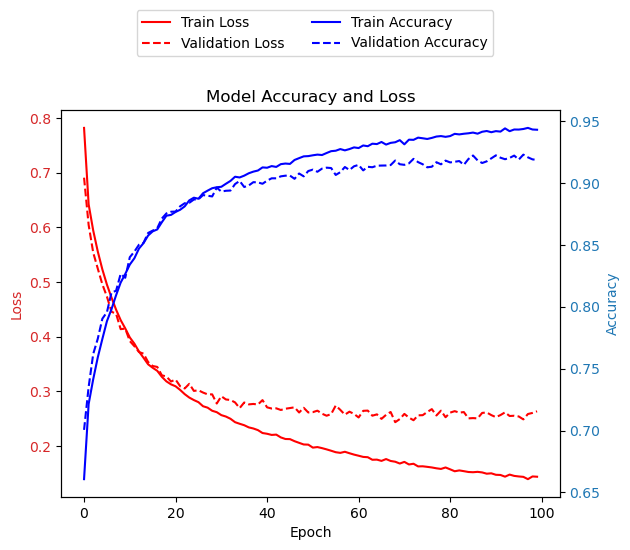

531/531 [==============================] - 5s 8ms/step


In [ ]:
# sample model
y_test, y_pred = train_v1(all_inputs, output_1)

In [ ]:
# check the validity of y_pred and y_test

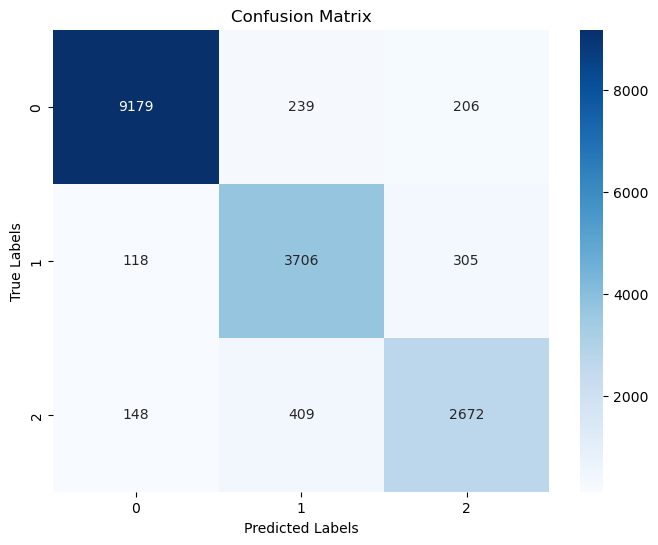

Classification Metrics:
Accuracy: 0.92
Precision: 0.89
Recall: 0.89
F1 Score: 0.89

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      9624
           1       0.85      0.90      0.87      4129
           2       0.84      0.83      0.83      3229

    accuracy                           0.92     16982
   macro avg       0.89      0.89      0.89     16982
weighted avg       0.92      0.92      0.92     16982

(0.9160876221881993, 0.887489305583346, 0.8929386970440628, 0.8899663843938691)


In [78]:
# this should work as well
print(pre.classification_metrics(y_test, y_pred, printed = True))

### Performing Grid-search on the base arcitecture, with all inputs

In [86]:
outlier_threshold_list = [0, 0.75, 1.5, 3]
input_output_combination_1 = [
     {'input':8, 'output':8},
     {'input':24, 'output':8},
     {'input':24, 'output':24},
     {'input':48, 'output':8},
     {'input':48, 'output':24},
     {'input':48, 'output':48},
     {'input':96, 'output':8},

]
input_output_combination_2 = [
     {'input':96, 'output':24},
     {'input':96, 'output':48},
     {'input':96, 'output':96},
     {'input':192, 'output':8},
     {'input':192, 'output':24},
     {'input':192, 'output':48},
     {'input':192, 'output':96},
     {'input':192, 'output':192},
]
epoch_num = 100
bacth_size = 200
# d1 = [0.1,0.3]
# d2 = [0.05, 0.15]
d1 = 0.1
d2 = 0.05
# 
cell_size = 80

In [ ]:
results_arr_1 = []
for outlier_threshold in outlier_threshold_list:
     for comb in input_output_combination_1:
          try:
               print('preprocessing...')
               input_window = comb['input'] #***
               output_window = comb['output'] #***

               # Initialize empty lists to store aggregated inputs and targets
               all_inputs = []
               all_targets = []

               # looping through symbols
               symbols = filtered_df['crypto_symbol'].unique()
               for s in symbols:
                    try:
                         sim_df = filtered_df[filtered_df['crypto_symbol'] == s]
                         sim_df.reset_index(inplace=True, drop=True)
                         # First Loop: Calculate intervals for each column without modifying the DataFrame
                         intervals = {}
                         for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                              lower, upper = pre.calculate_iqr_bounds(sim_df[column],outlier_threshold)
                              intervals[column] = {'lower_bound': lower, 'upper_bound': upper}

                         # getting the returns
                         reduced_df = sim_df.copy()
                         reduced_df['returns'] = pre.calculate_hourly_returns(reduced_df, 'date', 'close')
                         reduced_df = reduced_df[reduced_df['returns'].notna()]
                         reduced_df.reset_index(inplace=True, drop=True)

                         # Second Loop: Filter rows based on the pre-calculated intervals
                         for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                              lower_bound = intervals[column]['lower_bound']
                              upper_bound = intervals[column]['upper_bound']
                              # Apply filtering based on pre-calculated bounds
                              reduced_df = reduced_df[(reduced_df[column] > lower_bound) & (reduced_df[column] < upper_bound)]

                         reduced_df.reset_index(inplace=True, drop=True)

                         # MinMax scaling
                         scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is (0, 1)

                         scaled_df = reduced_df.copy()
                         scaled_df['lending_rate'] = scaler.fit_transform(reduced_df[['lending_rate']])
                         scaled_df['borrowing_rate'] = scaler.fit_transform(reduced_df[['borrowing_rate']])
                         scaled_df['utilization_rate'] = scaler.fit_transform(reduced_df[['utilization_rate']])
                         scaled_df['close'] = scaler.fit_transform(reduced_df[['close']])
                         scaled_df['volume'] = scaler.fit_transform(reduced_df[['volume']])
                         scaled_df['returns'] = scaler.fit_transform(reduced_df[['returns']])

                         inputs, targets = pre.extract_valid_windows_v2(
                              scaled_df,
                              'date', 
                              input_window, output_window, 
                              input_columns, 
                              ['lending_rate','borrowing_rate']
                              )

                         # Append results from the current DataFrame
                         all_inputs.append(inputs)
                         all_targets.append(targets)
                    except Exception as e:
                         # Handle any other exceptions
                         print(f"Unexpected error in symbol {s}: {e}")

               # Concatenate all inputs and targets into single arrays
               all_inputs = np.concatenate(all_inputs, axis=0) if all_inputs else np.array([])
               all_targets = np.concatenate(all_targets, axis=0) if all_targets else np.array([])

               # Lending rate
               output_1 = all_targets[:, 0].reshape(all_targets.shape[0], 1) 
               # Borrowing rate
               output_2 = all_targets[:, 1].reshape(all_targets.shape[0], 1) 
               total_windows = output_1.shape[0] #***
               print('training ...')
               y_test, y_pred = train_v1(all_inputs, output_1, details=False)
               
               accuracy, precision, recall, f1 = pre.classification_metrics(y_test, y_pred, printed = False)

               new_row = {
                    'total_windows':total_windows,
                    'input_window':input_window,
                    'output_window':output_window, 
                    'outlier_threshold':outlier_threshold, 
                    'accuracy':accuracy, 
                    'precision':precision, 
                    'recall':recall, 
                    'f1':f1
               }
               results_arr_1.append(new_row)
               print(new_row)
          except:
               print('error occured: ', outlier_threshold, comb)

results_1 = pd.DataFrame(results_arr_1)
     

preprocessing...
training ...


In [ ]:
results_arr_2 = []
for outlier_threshold in outlier_threshold_list:
     for comb in input_output_combination_2:
          try:
               print('preprocessing...')
               input_window = comb['input'] #***
               output_window = comb['output'] #***

               # Initialize empty lists to store aggregated inputs and targets
               all_inputs = []
               all_targets = []

               # looping through symbols
               symbols = filtered_df['crypto_symbol'].unique()
               for s in symbols:
                    try:
                         sim_df = filtered_df[filtered_df['crypto_symbol'] == s]
                         sim_df.reset_index(inplace=True, drop=True)
                         # First Loop: Calculate intervals for each column without modifying the DataFrame
                         intervals = {}
                         for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                              lower, upper = pre.calculate_iqr_bounds(sim_df[column],outlier_threshold)
                              intervals[column] = {'lower_bound': lower, 'upper_bound': upper}

                         # getting the returns
                         reduced_df = sim_df.copy()
                         reduced_df['returns'] = pre.calculate_hourly_returns(reduced_df, 'date', 'close')
                         reduced_df = reduced_df[reduced_df['returns'].notna()]
                         reduced_df.reset_index(inplace=True, drop=True)

                         # Second Loop: Filter rows based on the pre-calculated intervals
                         for column in ['lending_rate', 'borrowing_rate', 'utilization_rate']:
                              lower_bound = intervals[column]['lower_bound']
                              upper_bound = intervals[column]['upper_bound']
                              # Apply filtering based on pre-calculated bounds
                              reduced_df = reduced_df[(reduced_df[column] > lower_bound) & (reduced_df[column] < upper_bound)]

                         reduced_df.reset_index(inplace=True, drop=True)

                         # MinMax scaling
                         scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is (0, 1)

                         scaled_df = reduced_df.copy()
                         scaled_df['lending_rate'] = scaler.fit_transform(reduced_df[['lending_rate']])
                         scaled_df['borrowing_rate'] = scaler.fit_transform(reduced_df[['borrowing_rate']])
                         scaled_df['utilization_rate'] = scaler.fit_transform(reduced_df[['utilization_rate']])
                         scaled_df['close'] = scaler.fit_transform(reduced_df[['close']])
                         scaled_df['volume'] = scaler.fit_transform(reduced_df[['volume']])
                         scaled_df['returns'] = scaler.fit_transform(reduced_df[['returns']])

                         inputs, targets = pre.extract_valid_windows_v2(
                              scaled_df,
                              'date', 
                              input_window, output_window, 
                              input_columns, 
                              ['lending_rate','borrowing_rate']
                              )

                         # Append results from the current DataFrame
                         all_inputs.append(inputs)
                         all_targets.append(targets)
                    except Exception as e:
                         # Handle any other exceptions
                         print(f"Unexpected error in symbol {s}: {e}")

               # Concatenate all inputs and targets into single arrays
               all_inputs = np.concatenate(all_inputs, axis=0) if all_inputs else np.array([])
               all_targets = np.concatenate(all_targets, axis=0) if all_targets else np.array([])

               # Lending rate
               output_1 = all_targets[:, 0].reshape(all_targets.shape[0], 1) 
               # Borrowing rate
               output_2 = all_targets[:, 1].reshape(all_targets.shape[0], 1) 
               total_windows = output_1.shape[0] #***
               print('training ...')
               y_test, y_pred = train_v1(all_inputs, output_1, details=False)
               
               accuracy, precision, recall, f1 = pre.classification_metrics(y_test, y_pred, printed = False)

               new_row = {
                    'total_windows':total_windows,
                    'input_window':input_window,
                    'output_window':output_window, 
                    'outlier_threshold':outlier_threshold, 
                    'accuracy':accuracy, 
                    'precision':precision, 
                    'recall':recall, 
                    'f1':f1
               }
               results_arr_2.append(new_row)
               print(new_row)
          except:
               print('error occured: ', outlier_threshold, comb)

results_2 = pd.DataFrame(results_arr_2)